In this notebook, we will solve the full MHD equations, where the induction equation is coupled to the momentum equation via the Lorentz Force. You are going to use a numerical code that uses a combination of operator splitting, upwind methods, and method of characteristics-constrained transport for MHD.

# Solving the MHD equations using numerical tools - Introduction to FARGO3D

#### Preparations

First we need to create a temporary folder in the virtual machine file system, because the ERDA filesystem where you normally store your files is extremely slow, and not well-suited for compiling large code bases.

In [1]:
import os
import shutil

In [2]:
# Get the current working directory
cwd = os.getcwd()
# Go to home folder, which is in the temporary filesystem of the virtual machine
home = '/home/jovyan'
os.chdir(home)

#### Cloning the code from a git repository

First, download the code from its git repository

In [3]:
!git clone https://bitbucket.org/fargo3d/public.git fargo3d
fargo_folder = os.getcwd()+'/fargo3d'

Cloning into 'fargo3d'...
Receiving objects: 100% (540/540), 318.64 KiB | 1.63 MiB/s, done.
Resolving deltas: 100% (295/295), done.


Next, we need to compile the source files. We will compile the code with an MHD setup called Orszag-Tang Vortex test (Orszag & Tang 1979).

#### Building the code (compilation)

In [4]:
os.chdir(fargo_folder)
!make clean
!make SETUP=otvortex >& log_compile #This is the Orszag-Tang Vortex test

rm: cannot remove '../scripts/bound_*.code': No such file or directory
rm: cannot remove '../bin/*': No such file or directory

Everything has been cleaned



### Running the code (evolve the MHD equations)

Next, let's run the code from the code directory

In [5]:
os.chdir(cwd) # change to exercise folder
os.system('rm -rf fargo3d setups std') # make sure nothing left-over from old runs is present
os.system('cp -f '+fargo_folder+'/fargo3d "'+cwd+'"')   # get executable
os.system('cp -rf '+fargo_folder+'/setups "'+cwd+'"')   # get setups
os.system('cp -rf '+fargo_folder+'/std "'+cwd+'"')      # extra config files

0

In [6]:
!./fargo3d -o "ny=128, nz=128, dt=0.05, ntot=10, outputdir=outputs/otvortex" setups/otvortex/otvortex.par


       !!!! WARNING !!!!

This is a sequential built of the ./fargo3d code
If you planned to run the MPI-parallel version,
then you MUST rebuild the executable. In this case,
 issue:
make PARALLEL=1 (or make para)

Any subsequent invocation of make will build an MPI version.


FARGO3D git version 2.0-16-gceef70c6
SETUP: 'otvortex'

The default output directory root is ./
Reading parameters file setups/otvortex/otvortex.par
The output directory is outputs/otvortex/
Process 0 created the directory outputs/otvortex/
I do not output the ghost values
Field2D Reduction2D has been created
Field Moment_Plus_X has been created
Field Moment_Minus_X has been created
Field2D Vxhy has been created
Field2D Vxhyr has been created
Field2D Vxhz has been created
Field2D Vxhzr has been created
Field2D Nshift has been created
Field2D Nxhy has been created
Field2D Nxhz has been created
Field Moment_Plus_Y has been created
Field Moment_Minus_Y has been created
Field Moment_Plus_Z has been created
Field Mom

Let's explore the output directory

In [7]:
ls outputs/otvortex/

bx0.dat   bz0.dat        gasdens7.dat     gasvx7.dat   gasvz7.dat
bx10.dat  bz10.dat       gasdens8.dat     gasvx8.dat   gasvz8.dat
bx1.dat   bz1.dat        gasdens9.dat     gasvx9.dat   gasvz9.dat
bx2.dat   bz2.dat        gasenergy0.dat   gasvy0.dat   IDL.var
bx3.dat   bz3.dat        gasenergy10.dat  gasvy10.dat  orbit0.dat
bx4.dat   bz4.dat        gasenergy1.dat   gasvy1.dat   outputgas.dat
bx5.dat   bz5.dat        gasenergy2.dat   gasvy2.dat   summary0.dat
bx6.dat   bz6.dat        gasenergy3.dat   gasvy3.dat   summary10.dat
bx7.dat   bz7.dat        gasenergy4.dat   gasvy4.dat   summary1.dat
bx8.dat   bz8.dat        gasenergy5.dat   gasvy5.dat   summary2.dat
bx9.dat   bz9.dat        gasenergy6.dat   gasvy6.dat   summary3.dat
by0.dat   domain_x.dat   gasenergy7.dat   gasvy7.dat   summary4.dat
by10.dat  domain_y.dat   gasenergy8.dat   gasvy8.dat   summary5.dat
by1.dat   domain_z.dat   gasenergy9.dat   gasvy9.dat   summary6.dat
by2.dat   gasdens0.dat   gasvx0.dat       gasvz0.dat   summ

The domain of the mesh is stored in the files:
- domain_x.dat
- domain_y.dat (it contains 6 ghost zones (3 at the beginning + 3 at the end, used for boundaries)
- domain_z.dat (it contains 6 ghost zones (3 at the beginning + 3 at the end, used for boundaries)

The hydrodynamics fields are: 
- gasdens%.dat
- gasvx%.dat 
- gasvy%.dat 
- gasvz%.dat

The magnetic fields are: 
- bx%.dat 
- by%.dat 
- bz%.dat

Setup related files are in "fargo3d/setups/otvortex/"

The MHD algorithm is in fargo3d/src/mhd.c

In [ ]:
os.system('cat '+fargo_folder+'/src/mhd.c')

### Let's plot some data

In [18]:
import numpy as np
import matplotlib.pyplot as plt
#Some customization
plt.rcParams['figure.figsize'] = (5, 5)
plt.rcParams['image.origin']   = 'lower'

We first create a class that will be useful to obtain the parameters used for each run.

In [20]:
class Parameters():
    """
    Class for reading the simulation parameters (taken from utils/python/parameters.py).
    input: string -> name of the parfile, normally variables.par
    """
    def __init__(self, directory=''):
        if len(directory) > 1:
            if directory[-1] != '/':
                directory += '/'
        try:
            params = open(directory+"variables.par",'r') #Opening the parfile
        except IOError:                  # Error checker.
            print("Check your directory.")
            return
        lines = params.readlines()     # Reading the parfile
        params.close()                 # Closing the parfile
        par = {}                       # Allocating a dictionary
        for line in lines:             # Iterating over the parfile
            name, value = line.split() # Spliting the name and the value (first blank)
            try:
                float(value)           # First trying with float
            except ValueError:         # If it is not float
                try:
                    int(value)         #                   we try with integer
                except ValueError:     # If it is not integer, we know it is string
                    value = '"' + value + '"'
            par[name] = value          # Filling the dictionary
        for name in par:               # Iterating over the dictionary
            exec("self."+name.lower()+"="+par[name]) # Making the atributes at runtime
            
def get_data(fieldname,n,params):
    """
    We load some scalar field (e.g., density, vx, Bx, etc...)
    and make it 2D (because for this exercise all our fields are 2D).
    """
    return np.fromfile(params.outputdir+fieldname+str(n)+".dat").reshape(params.nz,params.ny)    

Example of use

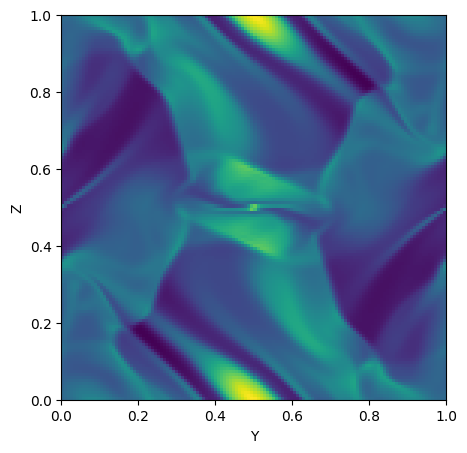

In [21]:
params = Parameters("outputs/otvortex/")

# In the notebook, if you now write params and press tab, 
# the autocompletion will show you all the parameters used 
# for the run
density = get_data("gasdens",10,params)
extent  = [params.ymin,params.ymax,params.zmin,params.zmax]
plt.imshow(density,extent=extent)
plt.xlabel("Y")
plt.ylabel("Z")
plt.show()

### Task 1: For the Orszag-Tang Vortex test, plot $B_y$, $B_z$, $V_y$ and $V_z$ for $t=0.5$

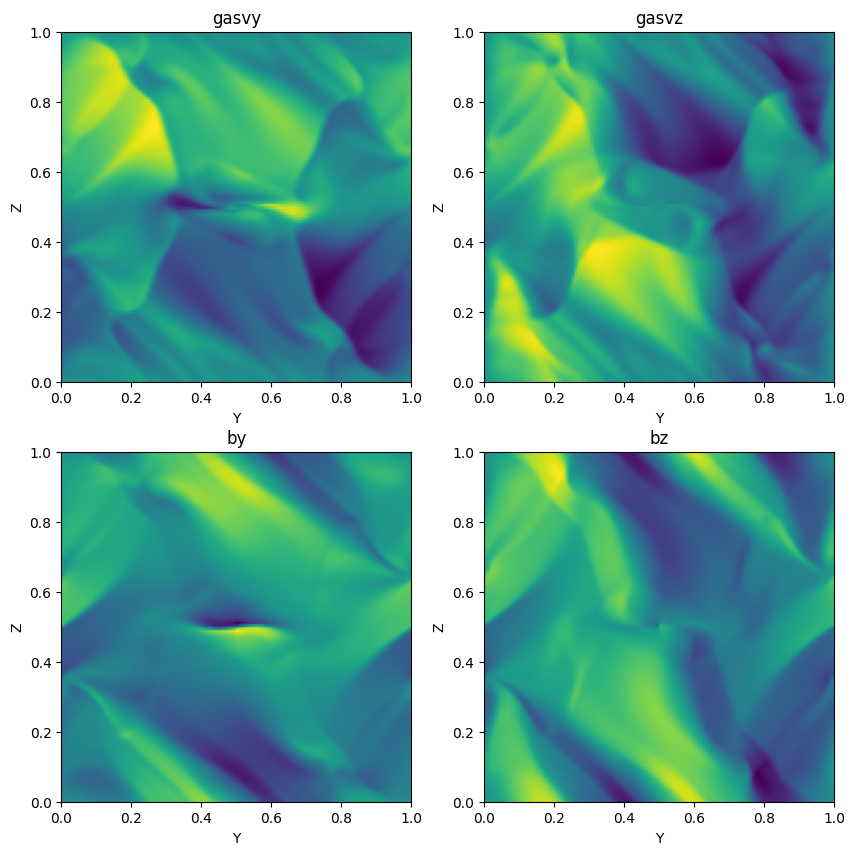

In [22]:
plt.figure(figsize=(10,10))
params = Parameters("outputs/otvortex/")
extent  = [params.ymin,params.ymax,params.zmin,params.zmax]
for i,name in enumerate(["gasvy","gasvz","by","bz"]):
    plt.subplot(2,2,i+1)
    plt.title(name)
    x = get_data(name,10,params)
    
    plt.imshow(x,extent=extent)
    plt.xlabel("Y")
    plt.ylabel("Z")
    

### Task 2: For the Orszag-Tang Vortex test, plot the streamlines and the magnetic lines 

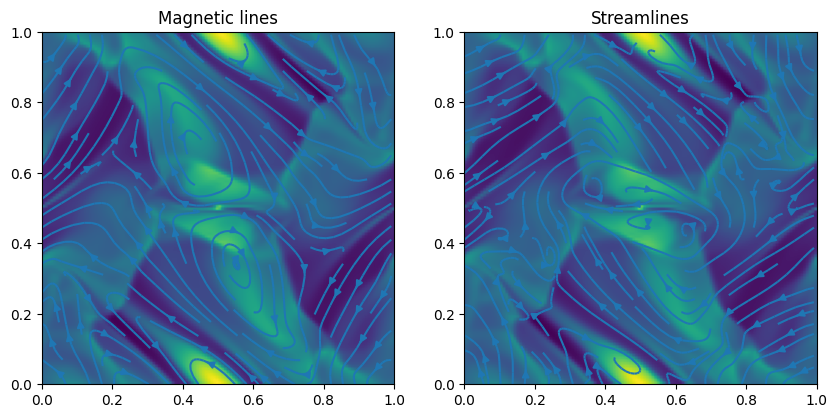

In [23]:
#We need the domian
n = 10

vy = np.fromfile('outputs/otvortex/gasvy'+str(10)+".dat").reshape(params.nz,params.ny)
vz = np.fromfile('outputs/otvortex/gasvz'+str(10)+".dat").reshape(params.nz,params.ny)
by = np.fromfile('outputs/otvortex/by'+str(10)+".dat").reshape(params.nz,params.ny)
bz = np.fromfile('outputs/otvortex/bz'+str(10)+".dat").reshape(params.nz,params.ny)

outputdir = params.outputdir

# We need a mesh with the domain for the task

# First, load the 1D arrays with the domain
y_1d  = np.loadtxt(params.outputdir+"domain_y.dat")[3:-4]
z_1d  = np.loadtxt(params.outputdir+"domain_z.dat")[3:-4]

# Now, create a 2D mesh using meshgrid
y_2d,z_2d = np.meshgrid(y_1d,z_1d)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("Magnetic lines")
plt.imshow(density,extent=[params.ymin,params.ymax,params.zmin,params.zmax])
plt.streamplot(y_2d,z_2d,by,bz)

plt.subplot(1,2,2)
plt.title("Streamlines")
plt.imshow(density,extent=[params.ymin,params.ymax,params.zmin,params.zmax])
plt.streamplot(y_2d,z_2d,vy,vz)

### Task 3: Calculate $\nabla \cdot {\bf B}$, plot it with imshow and verify $\nabla \cdot {\bf B} = 0$ for all the mesh. Consider the solution at $t = 0.5$

$\nabla \cdot {\bf B} = \partial_x B_x + \partial_y B_y + \partial_z B_z$, which in finite differences it reads:

In this problem, $B_x = 0$, so:
\begin{equation}
\nabla \cdot {\bf B} = \frac{{B_y}_{jk}-{B_y}_{j-1k}}{\Delta y} + \frac{{B_z}_{jk}-{B_z}_{jk-1}}{\Delta z}
\end{equation}

Tip: remember that $\Delta y$ and $\Delta z$ are constant, so, if the divergence is zero, then you only need to show that:
\begin{equation}
{B_y}_{jk}-{B_y}_{j-1k} + {B_z}_{jk}-{B_z}_{jk-1} = 0
\end{equation}

[[ 2.25514052e-17  5.55111512e-17  1.52655666e-16 ...  6.24500451e-17
  -1.38777878e-17 -5.20417043e-17]
 [-8.84708973e-17  1.17961196e-16 -3.46944695e-17 ... -2.08166817e-16
   1.14491749e-16  5.81132364e-17]
 [-4.16333634e-17  1.45716772e-16 -9.71445147e-17 ... -2.01227923e-16
  -9.02056208e-17  8.20741045e-17]
 ...
 [ 8.23993651e-17 -9.02056208e-17 -2.01227923e-16 ... -9.71445147e-17
   1.45716772e-16 -3.98986399e-17]
 [ 5.72458747e-17  1.14491749e-16 -2.08166817e-16 ... -3.46944695e-17
   1.21430643e-16 -8.84708973e-17]
 [-5.20417043e-17 -1.04083409e-17  6.24500451e-17 ...  1.52655666e-16
   5.55111512e-17  2.25514052e-17]]


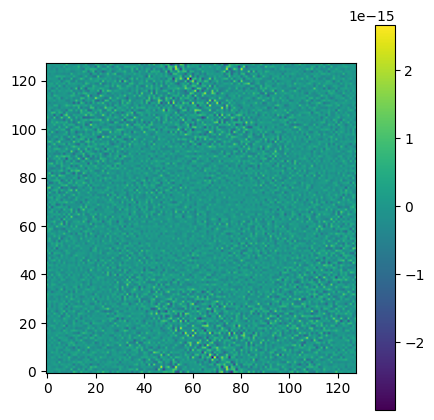

In [25]:
n  = 10
by = np.fromfile('outputs/otvortex/by'+str(10)+".dat").reshape(params.nz,params.ny)
bz = np.fromfile('outputs/otvortex/bz'+str(10)+".dat").reshape(params.nz,params.ny)
divB = -by+np.roll(by,-1,axis=1)-bz+np.roll(bz,-1,axis=0)
print(divB)
plt.imshow(divB) 
plt.colorbar()

We covered the basics of the code. You can find further documentation in https://fargo3d.bitbucket.io/, and the algorithms used in https://ui.adsabs.harvard.edu/abs/2016ApJS..223...11B/abstract

---------------------

### Linear MRI test

You are going to learn how to use FARGO3D to measure the growth rate of the magnetorotational instability (MRI) and compare it to the values predicted by linear perturbation analysis.

The methods and results of this exercise not only validates the correctness of the solver implemented in a numerical code but also serve as a starting point for studying the so-called nonlinear regime of the MRI.

### Preliminaries

The magnetorotational instability (MRI) can be derived using the shearing-sheet approximation, which consists of a local expansion of the equations around a fiducial radius in a rotating frame within a disk. 

This treatment allows us to neglect the curvature terms and simplify the equations while maintaining important physical properties of the system (like the shear and non-inertial forces in the case of an astrophysical disk).

In order to derive the equations leading to the MRI, we linearize the Navier-Stokes + Induction equations in the incompressible limit ($\nabla \cdot {\bf v}$) = 0 over a constant background magnetic field along the vertical direction $z$ and a constant sheared background (see, e.g. chapter 14.9 from the Theoretical Astrophysics course for more details). We only assume perturbations in the plane.

After writing the perturbations in Fourier space ($\delta \propto \hat{\delta} e^{ik z+\omega t}$), we get the following set of equations for the perturbations:

\begin{align}
\tilde{\omega} \delta v_x  &= 2 \delta v_y + i\tilde{k}\delta b_x, \nonumber \\
\tilde{\omega} \delta v_y  &= -\frac{1}{2} \delta v_x + i\tilde{k} \delta b_y, \nonumber \\
\tilde{\omega} \delta b_x &= i\tilde{k}\delta v_x, \nonumber \\
\tilde{\omega} \delta b_y  &= -\frac{3}{2} \delta b_x + i\tilde{k} \delta v_y,\nonumber \\ \nonumber 
\end{align}

where $\delta b_{x,y}$ = $\delta B_{x,y}/\sqrt{\mu_0\rho}$, $\tilde{k} = k v_A/\Omega_0$ with $v_A = B_z/\sqrt{\mu_0\rho}$ the Alfvén speed and $\tilde{\omega} = \omega/\Omega_0$. For simplicity, we have omitted the "hat" symbols, but remember that perturbations correspond to the Fourier components (which are in general complex quantities).

By defining the vector $\vec{\delta} \equiv [\delta v_x, \delta v_y, \delta b_x, \delta b_y]$, the system can be written as:

\begin{equation}
L\delta = \tilde{\omega} \delta
\end{equation}
with $L$ given by:

\begin{equation}
L=
\begin{bmatrix}
0 & 2 & i\tilde{k} & 0 \\
-1/2 & 0 & 0 & i\tilde{k} \\
i\tilde{k} & 0 & 0 & 0 \\
0 & i\tilde{k} & -3/2 & 0 \\
\end{bmatrix},
\end{equation}

In this way, we have reduced the problem to an eigenvalue problem (whose solution gives us the dispersion relation  of the problem, i.e., the pair $k,\omega$ such that non-trivial solution for the perturbations exists. 

#### Dispersion relation

The characteristic equation ($\det(L-\omega I) = 0$) is:

\begin{equation}
\omega^4+\left(2\tilde{k}^2 + 1\right) \omega^2 + \tilde{k}^2\left(\tilde{k}^2 - 3 \right) = 0 .
\end{equation}

This is a parabola in $\omega^2$ and the (4) roots are:

\begin{equation}
\omega = \pm\left[ -\frac{1 + 2\tilde{k}^2}{2} \pm \frac{1}{2}\sqrt{1+16\tilde{k}^{2}}\right]^{1/2}.
\end{equation}

One of these eigenvalues is real and positive (under conditions you can easily determine), leading to an exponential growth of the perturbations. This exponential growth is called the Magnetorotational instability. 

The unstable eigenvalue is:

\begin{equation}
{\omega_{\rm unstable}} = \left[ -\frac{1 + 2\tilde{k}^2}{2} + \frac{1}{2}\sqrt{1+16\tilde{k}^{2}}\right]^{1/2}
\end{equation}

### Task 1 

- Plot the dispersion relation of the instability (i.e., growth rate ($\omega_{\rm unstable}$) as a function of $\tilde{k}$ (assume $\tilde{k}>0$).
    
- Show that the maximum growth rate occurs at $\tilde{k}_\text{max} = \sqrt{15}/4$ and prove that it is equal to $\omega_\text{max} = 3/4$.
    
- Show that there is a cut-off at $\tilde{k}_\text{cut-off} = \sqrt{3}$ (i.e., for $\tilde{k}>\tilde{k}_{\rm cut-off}$, $\omega_{\rm unstable}$ is not real anymore).

The maximum value of omega is 0.75 and occurs 0.97
The cut-off is happening at 1.73


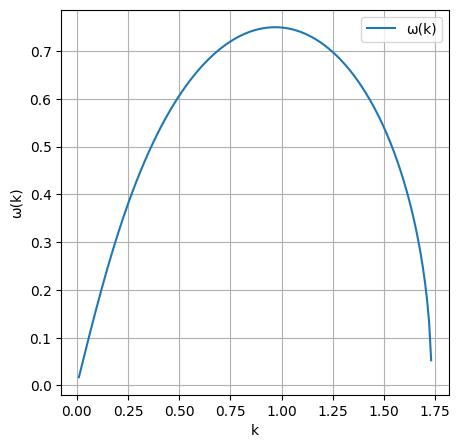

In [7]:
n=10000
x=np.linspace(0,100,n)
k=[]
omega=[]
for i in range(len(x)):
    a=-(1+2*x[i]**2)
    b=np.sqrt(1+16*x[i]**2)
    if a+b>0:
        omega.append(np.sqrt(0.5*(a+b)))
        k.append(x[i])
k=np.asarray(k)
omega=np.asarray(omega)


plt.plot(k,omega,label='ω(k)')
plt.grid()
plt.xlabel('k')
plt.ylabel('ω(k)')
plt.legend()

mx=omega[0]
index=0
for i in range(1,len(omega)):
    if omega[i]>mx:
        mx=omega[i]
        index=i
print(f"The maximum value of omega is {mx:.2f} and occurs {k[index]:.2f}")
mn=omega[index]
index1=0
for i in range(index,len(omega)):
    if omega[i]<mn:
        mn=omega[i]
        index1=i
print(f"The cut-off is happening at {k[index1]:.2f}")    

### Evolution of an isolated mode

Once the eigenvalues of the operator $L$ are known, the eigenvectors can be obtained (for each eigenvalue), and the linear solution of the system, for each particular mode, can be written as:
\begin{align}
\delta v_x(z,t)  &= \frac{A}{N} \tilde{\omega} \sin{\left(kz\right)} e^{\omega t} \nonumber \\
\delta v_y(z,t)   &= \frac{A}{N} \frac{\tilde{\omega}^2 + \tilde{k}^2}{2} \sin{\left(kz\right)} e^{\omega t} \nonumber  \\
\delta b_x(z,t)  &= \frac{A}{N}\tilde{k} \cos{\left(kz\right)} e^{\omega t} \nonumber \\
\delta b_y(z,t)  &= -\frac{A}{N} \frac{2\tilde{k}\tilde{\omega}}{\tilde{\omega}^2 + \tilde{k}^2} \cos{\left(kz\right)} e^{\omega t} \nonumber 
\end{align}

where $N$ is a normalization factor for the eigenvectors, given by 

\begin{equation}
N = \sqrt{\tilde{\omega}^2 + \left(\frac{\tilde{\omega}^2 + \tilde{k}^2}{2}\right)^2 + \tilde{k}^2 + \left(\frac{2\tilde{k}\tilde{\omega}}{\tilde{\omega}^2 + \tilde{k}^2}\right)^2}
\end{equation} 

The initial amplitude of the perturbations is given by $A$. (Note: the solution for any arbitrary initial condition is can now be obtained as the linear combination of these four modes)


### Task 2 - Using FARGO3D, measure the linear growth rate $\omega$ of the MRI for different values of $\tilde{k}$

Now we will recover the evolution of the unstable mode by solving the full set of nonlinear MHD equations from very small perturbations, so the linear approximation remains valid. In other words, the goal of the exercise is to use FARGO3D to build the dispersion relation numerically, exciting the unstable mode to measure the corresponding growth rate.

### Guideline

#### Step 1 - Incorporating a new setup

Copy the file "mri-growth-sb.zip" to fargo3d/setups/.
Opening the Terminal you can unpack the file using the command "unzip FILENAME". Once you have unzip'ed the file, you can compile the code with the MRI setup.

**remember** that the file should be copied to the temporary folder where the full fargo-3d code resides. That is in /home/jovyan/fargo. From the terminal something like

`cp mri-growth-sb.zip /home/jovyan/fargo3d/setups`

`cd /home/jovyan/fargo3d/setups`

`unzip mri-growth-sb.zip`

should do the trick.

We first clean the code (remove the executable and compiled sources that were used for the previous setup)

In [22]:
os.chdir(fargo_folder)
!make clean


Everything has been cleaned



And compile the code again, but with the new setup "mri-growth-sb"

In [23]:
!make SETUP=mri-growth-sb > build_mri_log

rm: cannot remove '../scripts/bound_*.code': No such file or directory
make[1]: [../src/makefile:610: clean] Error 1 (ignored)
rm: cannot remove '../bin/*': No such file or directory
make[1]: [../src/makefile:611: clean] Error 1 (ignored)
../src/psys.c: In function ‘AllocPlanetSystem’:
../src/psys.c:68:30: warning: ‘%s’ directive writing up to 511 bytes into a region of size 506 []8;;https://gcc.gnu.org/onlinedocs/gcc/Warning-Options.html#index-Wformat-overflow=-Wformat-overflow=]8;;]
   68 |     sprintf (command, "touch %s/orbit%d.dat", OUTPUTDIR, i);
      |                              ^~               ~~~~~~~~~
../src/psys.c:68:23: note: directive argument in the range [0, 2147483646]
   68 |     sprintf (command, "touch %s/orbit%d.dat", OUTPUTDIR, i);
      |                       ^~~~~~~~~~~~~~~~~~~~~~
In file included from /usr/include/stdio.h:894,
                 from /usr/include/malloc.h:25,
                 from ../src/fargo3d.h:9,
                 from ../src/psys.c:1:

Before running the code, have a look at the initial condition file (setups/mri-growth-sb/condinit.c) and the parameters file (setups/mri-growth-sb/mri-growth-sb.par), which allows you to modify the parameters of the run.

Any parameter there can also be changed at execution time through the flag "-o",

e.g.: 
           
    ./fargo3d -o "dt=0.1 nx=32 ny=32" setups/mri-growth-sb/mri-growth-sb.par

#### Comment about the initial condition
	
In the file "condinit.c", the eigenvectors are initialized proportional to trigonometric functions with argument $\left(2\pi z/\Delta Z\right)$, with $\Delta Z = Z_\text{max}-Z_\text{min}$. This is equivalent to considering the wave number $k = 2\pi/\Delta Z$. So, in order to change the excited mode, it is enough to change the vertical size of the box.

The size $\Delta Z$ of the box is related to the wave number $k$ and the parameters of the problem by the following relation:

\begin{equation}
k = \frac{2\pi}{\Delta Z} = \frac{\tilde{k} \Omega_0}{v_{\rm A}} \Longrightarrow \Delta Z = \frac{2\pi v_{\rm A}}{\tilde{k}  \Omega_0}.
\end{equation}

With the default values provided in the setup, $v_A \simeq 0.003162$, so the maximum growth rate occur (at $\tilde{k}_{\text{max}} = \sqrt{15}/4$) at:

\begin{equation}
\Delta Z_\text{max} \simeq 0.0205 
\end{equation}
	
which is the default "Zmax" value in the parameters file. 

Thus, in order to measure the dispersion relation, we will only modify the vertical extension of the box Zmax.

------------

#### Step 2 - Running the code with the new setup

In [24]:
os.chdir(fargo_folder)
!make #just in case you have modified some source file
os.chdir(cwd) # change to exercise folder
os.system('rm -rf fargo3d setups std') # make sure nothing left-over from old runs is present
os.system('cp -f '+fargo_folder+'/fargo3d "'+cwd+'"')   # get executable
os.system('cp -rf '+fargo_folder+'/setups "'+cwd+'"')   # get setups
os.system('cp -rf '+fargo_folder+'/std "'+cwd+'"')      # extra config files
!./fargo3d -o "dt=0.1 zmax=0.0205 ny=32 nz=32" setups/mri-growth-sb/mri-growth-sb.par

make[1]: Entering directory '/home/jovyan/fargo3d/bin'
make[1]: '../src/rescale.c' is up to date.
make[1]: Leaving directory '/home/jovyan/fargo3d/bin'
make[1]: Entering directory '/home/jovyan/fargo3d/bin'

          FARGO3D SUMMARY:           

This built is SEQUENTIAL. Use "make para" to change that


SETUP:      'mri-growth-sb'         
(Use "make SETUP=[valid_setup_string]" to change set up)
(Use "make list" to see the list of setups implemented)
(Use "make info" to see the current sticky build options)

make[1]: Leaving directory '/home/jovyan/fargo3d/bin'

       !!!! WARNING !!!!

This is a sequential built of the ./fargo3d code
If you planned to run the MPI-parallel version,
then you MUST rebuild the executable. In this case,
 issue:
make PARALLEL=1 (or make para)

Any subsequent invocation of make will build an MPI version.


FARGO3D git version 2.0-16-gceef70c6
SETUP: 'mri-growth-sb'

The default output directory root is ./
Reading parameters file setups/mri-growth-sb/mri-gr

#### Step 3 - For fixed $y_0$, plot $B_x(y_0,z)$ for output numbers 5, 10, and 15 (in the same axis). Explain what you observe.
 
Let's concentrate on the solution for the component $B_x$, which is:

\begin{align}
\delta b_x(z,t) \propto \cos{\left(kz\right)} e^{\omega t} \nonumber \\
\end{align}

Note that for this task, the proportionality factors are not important. Since the solution does not depend on $y$, we can just plot a cut along the $z$-direction. Furthermore, we can also anticipate what we should observe: a trigonometric function whose amplitude grows with time exponentially.

Example of cut:

    get_data("bx",3,params)[:,params.ny//2]

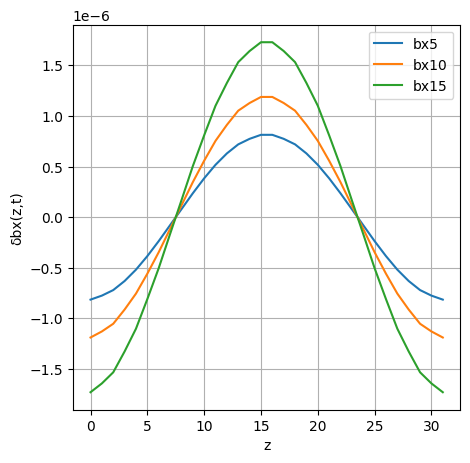

In [8]:
params = Parameters("outputs/mri-growth-sb/")
bx5=get_data("bx",5,params)[:,params.ny//2]
bx10=get_data("bx",10,params)[:,params.ny//2]
bx15=get_data("bx",15,params)[:,params.ny//2]
plt.plot(bx5,label='bx5')
plt.plot(bx10,label='bx10')
plt.plot(bx15,label='bx15')
plt.legend()
plt.xlabel('z')
plt.ylabel('δbx(z,t)')
plt.grid()

---------------

#### Step 4 - Using $B_x$, measure the growth-rate $\omega$ for the results from step2. Plot the value measured on top of the dispersion relation obtained analitically.

Tip 1:

The solution is of the form:
\begin{align}
\delta b_x(z,t) \propto \cos{\left(kz\right)} e^{\omega t} \nonumber
\end{align}

so, if we fix $z=z_0$:
\begin{align}
\delta b_x(z_0,t) = C e^{\omega t} \nonumber
\end{align}

with $C$ a constant, i.e., the perturbation must growth exponentially. 

Now, we can calculate:

\begin{equation}
\log|\delta b_x (z_0,t)| = \omega t + \log(C)
\end{equation}

Previous expression shows that we can measure the growth rate by plotting $\log(\delta b_x)$ ($B_x$ in our setup) as a function of time, which is a straight line. Furthermore, we can use a simple linear regresion to determine the slope (growth rate) from our data. (Check the function np.polyfit())

Tip 2: The time corresponding to each output can be obtained as:

    time = params.dt * params.ninterm * i 

where i is the output number

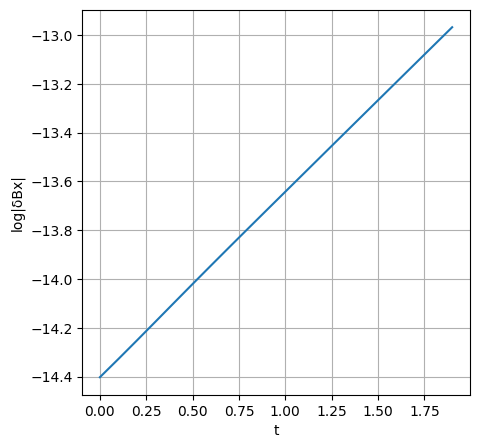

In [25]:
params = Parameters("outputs/mri-growth-sb/")

# We store the data in two lists    
bx   = []
time = []

for i in range(20):
    time.append(params.dt * params.ninterm * i)
    bx.append(np.max(get_data("bx",i,params)[:,params.ny//2]))

# We convert the lists to arrays so we can use numpy to modify them (if needed)
time = np.array(time)
bx   = np.array(bx)

# And plot it
plt.plot(time,np.log(np.abs(bx)))
plt.xlabel('t')
plt.ylabel('log|δBx|')
plt.grid()
plt.show()

Now, we can use np.polyfit to obtain the slope of the curve

The value of the slope is equal to 0.755


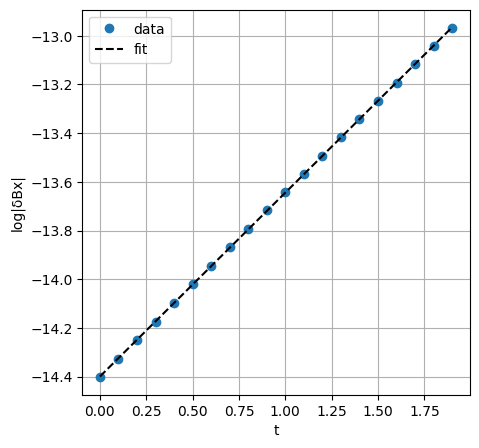

In [33]:
# Polyfit gives us the coefficients of the polynomial a*x+b
a,b = np.polyfit(time,np.log(np.abs(bx)),1)

x = np.linspace(time.min(),time.max(),100) # We create a domain array
y = a*x+b  # This is our fit
print(f'The value of the slope is equal to {a:.3f}')
# And finally compare our fit with the data
plt.plot(time,np.log(np.abs(bx)),'o',label='data')
plt.plot(x,y,'k--',label='fit')
plt.legend()
plt.xlabel('t')
plt.ylabel('log|δBx|')
plt.grid()
plt.show()

As we can see, the fit is excellent! Now, we can plot the measured growth rate (a) on top of our analytical dispersion relation:

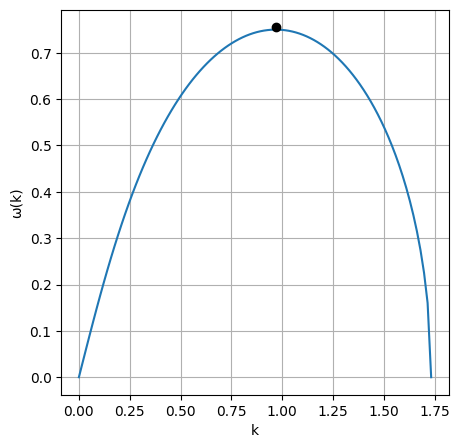

In [27]:
# This is the dispersion relation

k_tilde = np.linspace(0,np.sqrt(3),100)
omega_unstable = np.sqrt(-0.5*(1 + 2*k_tilde**2) + 0.5*np.sqrt(1+16*k_tilde**2))
plt.plot(k_tilde,omega_unstable)
plt.xlabel('k')
plt.ylabel('ω(k)')
plt.grid()

# And now we plot the measured value
k_tilde_experiment = np.sqrt(15)/4.0
omega_experiment = a

plt.plot(k_tilde_experiment,omega_experiment,'ko')


#### Step 5 - Determine the growth rate for all these values: 

$\Delta Z$ = [0.0911,  0.0514,  0.0358,  0.0274 ,	0.0223,  0.0188,  0.0162,  0.0142 ,  0.0127] and plot the pairs (${\tilde k},\omega$) for all the cases in one figure, on top of the analytical solution (as done above).

For each run, you can obtain the corresponding $\tilde{k}$ from the terminal. Tip: in order to save time (and minimize the probability of typos), the lines needed to run the code can be generated automatically using strings.

In [70]:
Dz = [0.0911, 0.0514, 0.0358, 
      0.0274, 0.0223, 0.0188, 
      0.0162, 0.0142, 0.0127]

# If you have time, you can play with different number of cells
# but the default for the exercise is 32.
ny      = 32  #Number of cells in the radial direction
nz      = 32  #Number of cells in the vertical direction
dt      = 0.2 #Time between outputs

for i,delta_z in enumerate(Dz):
    arguments = '"zmax={0:4.4f} outputdir=outputs/output{1:d} ny={2:d} nz={3:d} dt={4:2.2f}"'.format(delta_z,i, ny, nz, dt)
    exec_line = "!./fargo3d -o "+arguments+" setups/mri-growth-sb/mri-growth-sb.par > log{0:d}".format(i)
    print(exec_line)

!./fargo3d -o "zmax=0.0911 outputdir=outputs/output0 ny=32 nz=32 dt=0.20" setups/mri-growth-sb/mri-growth-sb.par > log0
!./fargo3d -o "zmax=0.0514 outputdir=outputs/output1 ny=32 nz=32 dt=0.20" setups/mri-growth-sb/mri-growth-sb.par > log1
!./fargo3d -o "zmax=0.0358 outputdir=outputs/output2 ny=32 nz=32 dt=0.20" setups/mri-growth-sb/mri-growth-sb.par > log2
!./fargo3d -o "zmax=0.0274 outputdir=outputs/output3 ny=32 nz=32 dt=0.20" setups/mri-growth-sb/mri-growth-sb.par > log3
!./fargo3d -o "zmax=0.0223 outputdir=outputs/output4 ny=32 nz=32 dt=0.20" setups/mri-growth-sb/mri-growth-sb.par > log4
!./fargo3d -o "zmax=0.0188 outputdir=outputs/output5 ny=32 nz=32 dt=0.20" setups/mri-growth-sb/mri-growth-sb.par > log5
!./fargo3d -o "zmax=0.0162 outputdir=outputs/output6 ny=32 nz=32 dt=0.20" setups/mri-growth-sb/mri-growth-sb.par > log6
!./fargo3d -o "zmax=0.0142 outputdir=outputs/output7 ny=32 nz=32 dt=0.20" setups/mri-growth-sb/mri-growth-sb.par > log7
!./fargo3d -o "zmax=0.0127 outputdir=out

In [120]:
!./fargo3d -o "zmax=0.0911 outputdir=outputs/output0 ny=32 nz=32 dt=0.20" setups/mri-growth-sb/mri-growth-sb.par > log0
!./fargo3d -o "zmax=0.0514 outputdir=outputs/output1 ny=32 nz=32 dt=0.20" setups/mri-growth-sb/mri-growth-sb.par > log1
!./fargo3d -o "zmax=0.0358 outputdir=outputs/output2 ny=32 nz=32 dt=0.20" setups/mri-growth-sb/mri-growth-sb.par > log2
!./fargo3d -o "zmax=0.0274 outputdir=outputs/output3 ny=32 nz=32 dt=0.20" setups/mri-growth-sb/mri-growth-sb.par > log3
!./fargo3d -o "zmax=0.0223 outputdir=outputs/output4 ny=32 nz=32 dt=0.20" setups/mri-growth-sb/mri-growth-sb.par > log4
!./fargo3d -o "zmax=0.0188 outputdir=outputs/output5 ny=32 nz=32 dt=0.20" setups/mri-growth-sb/mri-growth-sb.par > log5
!./fargo3d -o "zmax=0.0162 outputdir=outputs/output6 ny=32 nz=32 dt=0.20" setups/mri-growth-sb/mri-growth-sb.par > log6
!./fargo3d -o "zmax=0.0142 outputdir=outputs/output7 ny=32 nz=32 dt=0.20" setups/mri-growth-sb/mri-growth-sb.par > log7
!./fargo3d -o "zmax=0.0127 outputdir=outputs/output8 ny=32 nz=32 dt=0.20" setups/mri-growth-sb/mri-growth-sb.par > log8


       !!!! WARNING !!!!

This is a sequential built of the ./fargo3d code
If you planned to run the MPI-parallel version,
then you MUST rebuild the executable. In this case,
 issue:
make PARALLEL=1 (or make para)

Any subsequent invocation of make will build an MPI version.
Reading parameters file setups/mri-growth-sb/mri-growth-sb.par

       !!!! WARNING !!!!

This is a sequential built of the ./fargo3d code
If you planned to run the MPI-parallel version,
then you MUST rebuild the executable. In this case,
 issue:
make PARALLEL=1 (or make para)

Any subsequent invocation of make will build an MPI version.
Reading parameters file setups/mri-growth-sb/mri-growth-sb.par

       !!!! WARNING !!!!

This is a sequential built of the ./fargo3d code
If you planned to run the MPI-parallel version,
then you MUST rebuild the executable. In this case,
 issue:
make PARALLEL=1 (or make para)

Any subsequent invocation of make will build an MPI version.
Reading parameters file setups/mri-growth-s

In [15]:
growth_rate=[]
k_tilded=np.array([0.218103,0.38656,0.555005,0.725152,0.890994,1.05687,1.22649,1.39924,1.5645])
for i in range(9):
    params = Parameters("outputs/output{}/".format(i))
    bx   = []
    time = []
 
    for i in range(20):
        time.append(params.dt * params.ninterm * i)
        bx.append(np.max(get_data("bx",i,params)[:,params.ny//2]))

        # We convert the lists to arrays so we can use numpy to modify them (if needed)
    time = np.array(time)
    bx   = np.array(bx)
    a,b = np.polyfit(time,np.log(np.abs(bx)),1)
    growth_rate.append(a)



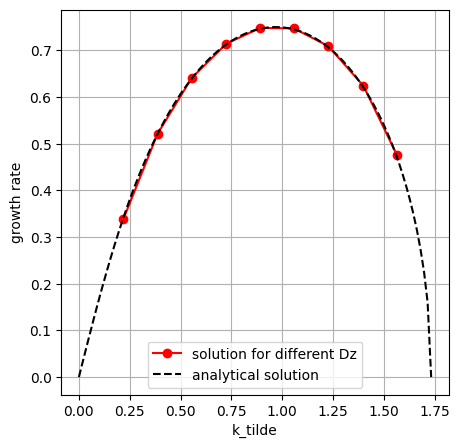

In [14]:
growth_rate=np.asarray(growth_rate)
plt.plot(k_tilded,growth_rate,'r',marker='o',label='solution for different Dz',)

k_tilde = np.linspace(0,np.sqrt(3),100)
omega_unstable = np.sqrt(-0.5*(1 + 2*k_tilde**2) + 0.5*np.sqrt(1+16*k_tilde**2))
plt.plot(k_tilde,omega_unstable,'k',ls='--',label='analytical solution')
plt.legend()
plt.xlabel('k_tilde')
plt.ylabel('growth rate')
plt.grid()
